# Modeling nucleic acid recovery from airplane filters
Lennart Justen
2023-01-25

Parameter estimates are in [this Gsheet](https://docs.google.com/spreadsheets/d/11WNgxjYTXM_cgXXY7NhlwtKz-FrHl5ZhDisSDDExdMo/edit?usp=sharing)

## Plane parameters
Consider a plane of volume $V$ and with number of passengers $N$, were some fraction of them $\zeta$ are infected with a pathogen. All passengers are in the plane for a total time $T$.

In [31]:
import numpy as np
import matplotlib.pyplot as plt

N = 200  # number of passengers (person)
zeta = 0.1  # percent of passengers infected
T = 8*60*60  # time on airplane (s)
V = 231000 # volume of plane (L)

## Nucleic acid generation
Two kinds of nucleic acid (NA) are generated by passengers: target (pathogen) NA and off-target NA. Every passenger, whatever their infection status, is assumed to shed off target NA while only passengers who are infected also shed target (pathogen) NA. Given per-person NA shedding rates, we can calculate the rate of change of NA concentration in the airplane in the absence of any air exchange.

$\frac{dc_{sp}(t)}{dt}  = \gamma_p\frac{\zeta N}{V}$ = *constant*, where

$\gamma_p$ = the rate of target pathogen NA shedding per person per second (ng person-1 s-1), and
$\frac{dc_{sp}}{dt}$  = the rate of change of target pathogen NA concentration (ng m-3 s-1) in the plane due to shedding.

The same holds for off-target NA, denoted by the $_o$ subscript.

$\frac{dc_{so}}{dt} = \gamma_o\frac{N}{V}$, where

$\gamma_o$ = the rate of off-target NA shedding per person per second (ng person-1 s-1), and
$\frac{dc_{so}}{dt}$  = the rate of change of off-target NA concentration (ng m-3 s-1) in the plane due to shedding.


In [32]:
gamma_p = 1.5*10**-6  # rate of target pathogen NA shedding per person per second (ng person-1 s-1)
# gamma_o = 0.1  # rate of off-target NA shedding per person per second (ng person-1 s-1)

## Nucleic acid removal
On- and off-target NA are removed from the airplane via a ventilation system coupled with a filter operating at some fixed air exchange per hour (ACH), or more helpfully, air changes per second (ACS).

$ACS = \frac{f}{V} = \frac{ACH}{60\cdot60}$, where

$f$ = flow rate (L/s), and
$V$  = volume of the plane (L)

Future versions of this model could include some decay constant representing NA settling to the ground or otherwise degrading in the air. This phenomenon would likewise contribute to the removal of NA but via a different mechanism.

In [33]:
fr = 700  # flow rate (L/s)



**Assumption 1:** assume that the return air is entirely "clean" i.e. has no nucleic acid content (I'll revist this later).

The change in NA concentration in the air due to its removal by the filter depends on the concentration of NA already in the air.

$\frac{dc_{rp}(t)}{dt}=ACS\cdot c_p(t)$, where

$\frac{dc_{rp}}{dt}$ = the rate of change in target pathogen NA concentration in the airplane due to removal by filter, and
$c_p$ = the concentration of the pathogen in the air.

As before, the same logic applied to off-target NA.


$\frac{dc_{ro}(t)}{dt}=ACS\cdot c_o(t)$, where

$\frac{dc_{ro}}{dt}$ = the rate of change in off-target NA concentration in the airplane due to removal by filter, and
$c_o$ = the concentration of off-target NA in the air.

## Concentration of NA in the air
We've now come up with expression for NA generation and removal, expressed in terms of the changes in concentration. From this, we can describe the overall rate of change of NA concentration as:

$\frac{c_p(t)}{dt} = \frac{c_{sp}}{dt}-\frac{c_{rp}}{dt} = \frac{\zeta N\gamma_p}{V} - ACS\cdot c_p(t)$


This turns out to be an ordinary differential equation of the form

$\frac{dy}{dt}=a-by$ where $a$ is a constant forcing function.

Solving the differential equation for $c_p(t)$ with the initial condition $c_p(0)=0$ we get

$c_p(t)=\frac{\zeta N\gamma_p}{V\cdot ACS}(1-e^{-ACS\cdot t})$

Once again, the same logic applied for $c_o$

$c_o(t) = \frac{N\gamma_s}{V\cdot ACS}(1-e^{-ACS\cdot t})$

In [34]:
def c_p(zeta, N, V, fr, gamma_p, t):
    # concentration of target pathogen NA as a function of time (ng L-1)
    return (zeta*N*gamma_p/fr)*(1-np.exp(-fr*t/V))

def c_o(N, V, fr, gamma_o, t):
    # concentration of off-target NA as a function of time (ng L-1)
    return (N*gamma_o/fr)*(1-np.exp(-fr*t/V))

## Collection of NA in filter
**Assumption 2: All air is driven through a filter in the airplane**
* Also, recall that Assumption 1 says that all return air in the airplane has no NA content. For a more detailed model, one could say that some amount of NA passes through the filter and is returned into the airplane.
* Another possible expansion is NA recovery efficiency i.e., the fraction of NA you actually end up sequencing compared to what was caught on the filter.

Consider that the filter through which air is moving has an efficiency $\eta$ for removing NA. Then we can express the amount of NA collected in the filter per unit time as

$\frac{m_p}{dt} = f\eta c_p$, where

$\frac{m_p}{dt}$ = the rate of collection of target pathogen NA (ng s-1), and as before
$f$ = flow rate (L s-1)

Plugging in our expression for $c_p$ and doing some rearranging, we get

$\frac{dm_p}{dt}=\eta\zeta N\gamma_p(1-e^{-ft/V})$

and likewise

$\frac{dm_o}{dt}=\eta N\gamma_o(1-e^{-ft/V})$

To calculate the total amount of NA collected over some time $T$ (in this case the duration of the flight), one need only integrate:

$m_p = \int_{0}^{T}\eta\zeta N\gamma_p(1-e^{-ft/V})dt = \eta\zeta N\gamma_p(\frac{e^{-fT/V}}{f/V}+T)$

In [35]:
eta = 99.97  # Filter efficiency
beta = 1   # NA sample recovery efficiency

def m_p(fr, eta, beta, t):
    return fr*eta*beta*c_p(zeta, N, V, fr, gamma_p, t)*t

## Visualizing the results

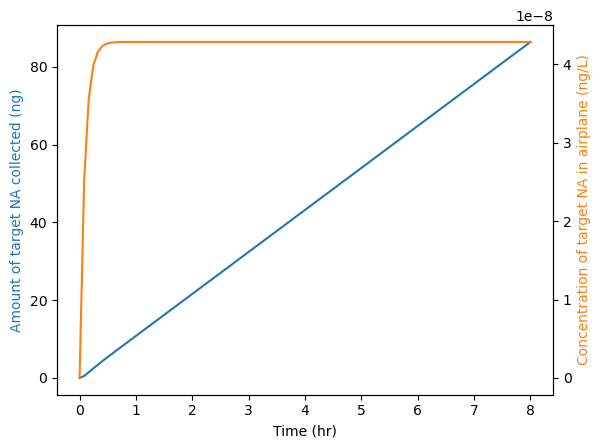

In [36]:
time = np.linspace(0,8,100)

mass_over_time = [m_p(fr, eta, beta, t*60*60) for t in time]
concentration_over_time = [c_p(zeta, N, V, fr, gamma_p, t*60*60) for t in time]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time, mass_over_time, 'C0')
ax2.plot(time, concentration_over_time, 'C1')

ax1.set_xlabel('Time (hr)')
ax1.set_ylabel('Amount of target NA collected (ng)', color='C0')
ax2.set_ylabel('Concentration of target NA in airplane (ng/L)', color='C1')

plt.show()

## Next steps
* Compare results to [Yang et al. (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3119883/) who measured Influenza A concentration in an airplane.
* Parameterize NA shedding rates
* Investigate NA recovery efficiency from HEPA filters.